In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import glob
import sys
import cv2 as cv
from tqdm import tqdm
tqdm.pandas()

from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from astropy.io import fits
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table

In [2]:
combine_fold = 'C:/Users/oryan/Documents/mergers-in-cosmos/cats-to-combine'
data_folder = 'C:/Users/oryan/Documents/mergers-in-cosmos/back-to-basics-data'
fig_folder = 'C:/Users/oryan/Documents/mergers-in-cosmos/paper-source/figures'
cos_dat_fold = 'E:/cosmos-data'

In [ ]:
df_cat = pd.read_csv(f'{combine_fold}/dor-all-restaged-full-rem-seps-z.csv', index_col = 0)

C:\Users\oryan\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
df_cat

,ID,ORyanID_23,category,ALPHA_J2000,DELTA_J2000,X_IMAGE,Y_IMAGE,ERRX2_IMAGE,ERRY2_IMAGE,ERRXY_IMAGE,...,ez_ssfr_p025,ez_ssfr_p160,ez_ssfr_p500,ez_ssfr_p840,ez_ssfr_p975,ez_Av_p025,ez_Av_p160,ez_Av_p500,ez_Av_p840,ez_Av_p975
0,816891,4000705532455,stage4,150.679846,2.196543,9200.399414,21737.232422,0.000052,0.000059,-1.043282e-05,...,-8.931825,-8.911355,-8.899668,-8.883307,-8.872990,0.529107,0.560142,0.599624,0.630920,0.652330
1,860686,4000705533383,stage3,150.644522,2.237226,10047.978516,22713.351562,0.000051,0.000046,1.571297e-06,...,-9.314209,-9.106611,-8.941274,-8.713107,-8.541205,0.341270,0.545498,0.732327,0.906665,1.020098
2,1301188,4000705539941,stage2,149.702462,2.654895,32637.949219,32737.013672,0.000064,0.000104,-2.881107e-06,...,-9.794128,-9.784252,-9.766013,-9.743796,-9.727879,0.018737,0.018737,0.018737,0.018737,0.018737
3,1304538,4000705540034,stage3,149.726828,2.658172,32053.712891,32815.468750,0.000071,0.000086,-6.036952e-06,...,-9.480532,-9.443615,-9.402433,-9.352081,-9.325659,0.302629,0.376027,0.440394,0.508153,0.567727
4,1310001,4000705540064,stage3,149.701230,2.660343,32667.441406,32867.789062,0.000026,0.000020,-1.023530e-05,...,-9.882174,-9.855921,-9.816085,-9.697225,-9.573506,0.455258,0.482555,0.522239,0.600383,0.660279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3927,1520733,4001204758614_extra,stage4,149.891374,2.866981,28107.876953,37826.437500,0.000086,0.000104,-9.313976e-07,...,-9.441206,-9.279022,-9.095134,-9.003501,-8.955496,0.120441,0.213251,0.306832,0.556012,0.731876
3928,1520749,4546055995_extra,stage2,150.383110,2.865367,16320.103516,37787.917969,0.000131,0.000236,7.123858e-05,...,-9.857880,-9.658215,-9.485625,-9.235816,-8.971795,0.162147,0.238640,0.432004,0.592193,0.687256
3929,1523385,4000927318133_extra,stage3,149.789910,2.865132,30540.179688,37782.648438,0.000045,0.000059,1.600747e-05,...,-9.525900,-9.472779,-9.353454,-9.273221,-9.213521,0.262676,0.355466,0.410356,0.489105,0.566003
3930,1524909,4000747939904_extra,stage3,150.450581,2.872371,14702.710938,37956.468750,0.000248,0.000292,7.378556e-06,...,-9.556987,-9.385500,-9.154130,-9.026810,-8.938077,0.153294,0.283249,0.436332,0.600615,0.693621


In [ ]:
df_red_tmp = df_cat.query('ez_sfr < 10')
df_red = df_red_tmp.query('lp_mass_best > 6.5')

In [ ]:
def picking_z(ez_z, lp_z):
    if np.isnan(ez_z):
        if not np.isnan(lp_z):
            return lp_z
        else:
            return np.nan
    
    if np.isnan(lp_z):
        if not np.isnan(ez_z):
            return ez_z
        else:
            return np.nan
    
    if lp_z < ez_z:
        return lp_z
    elif ez_z <= lp_z:
        return ez_z
    else:
        return 'what'

In [8]:
df_z_tmp = (
    df_red[['ORyanID_23', 'ID', 'category', 'ALPHA_J2000', 'DELTA_J2000', 'lp_mass_best', 'ez_sfr', 'lp_zBEST', 'ez_z_phot', 'ID_COSMOS2015']]
    .assign(redshift = df_red.apply(lambda row: picking_z(row.ez_z_phot, row.lp_zBEST), axis = 1))
    .assign(contains_extra = df_red.ORyanID_23.apply(lambda x: 'y' if type(x) == str else 'n'))
)
df_z = df_z_tmp.query('redshift < 1.2').drop(columns = ['contains_extra'])

In [9]:
df_z

,ORyanID_23,ID,category,ALPHA_J2000,DELTA_J2000,lp_mass_best,ez_sfr,lp_zBEST,ez_z_phot,ID_COSMOS2015,redshift
0,4000705532455,816891,stage4,150.679846,2.196543,9.28590,0.589695,0.5304,0.519525,590539,0.519525
1,4000705533383,860686,stage3,150.644522,2.237226,10.44862,1.609304,1.1244,1.198015,618751,1.124400
2,4000705539941,1301188,stage2,149.702462,2.654895,8.72372,-0.987761,NaN,0.230293,893328,0.230293
3,4000705540034,1304538,stage3,149.726828,2.658172,9.96798,1.101499,NaN,1.024009,895502,1.024009
4,4000705540064,1310001,stage3,149.701230,2.660343,10.41827,1.083541,0.4864,0.501348,898397,0.486400
...,...,...,...,...,...,...,...,...,...,...,...
3927,4001204758614_extra,1520733,stage4,149.891374,2.866981,9.27097,0.369745,NaN,0.484922,1030872,0.484922
3928,4546055995_extra,1520749,stage2,150.383110,2.865367,9.50357,0.507741,NaN,0.647512,1029954,0.647512
3929,4000927318133_extra,1523385,stage3,149.789910,2.865132,9.53909,0.406027,NaN,0.301645,1031020,0.301645
3930,4000747939904_extra,1524909,stage3,150.450581,2.872371,9.76084,0.637714,NaN,0.855695,1034203,0.855695


### Cross Matching with AGN Catalogues

In [10]:
with fits.open(f'{cos_dat_fold}/VLA_3GHz_counterpart_array_20170210_paper_smolcic_et_al.fits') as hdul:
    smol_rec = hdul[1].data

In [11]:
smol_df = Table(smol_rec).to_pandas().query('CAT_CPT == "COSMOS2015     "')

In [12]:
def getting_smol_info(clsfs_nostrip, flag):
            
    if flag != 0:
        return 'no_COSMOS'
    
    clsfs = []
    for j in clsfs_nostrip:
        clsfs.append(j.strip())
    
    if clsfs[0] == 'true':
        return 'AGN'
    elif clsfs[1] == 'true':
        return 'AGN'
    elif clsfs[2] == 'true':
        return 'AGN'
    elif clsfs[3] == 'true':
        return 'AGN'
    elif clsfs[4] == 'true':
        return 'SFG'
    elif clsfs[5] == 'true':
        return 'SFG'
    elif clsfs[6] == 'true':
        return 'AGN'
    elif clsfs[7] == 'true':
        return 'AGN'
    elif clsfs[8] == 'true':
        return 'AGN'
    else:
        return 'unknown'

In [13]:
smol_clsf = (
    smol_df.assign(gal_clsf = smol_df.progress_apply(lambda row: getting_smol_info(
        [
            row.Xray_AGN, 
            row.MIR_AGN, 
            row.SED_AGN, 
            row.Quiescent_MLAGN, 
            row.SFG, 
            row.Clean_SFG,
            row.HLAGN,
            row.MLAGN,
            row.Radio_excess
        ], 
        row.flag_COSMOS2015), axis = 1)
                  )
)

100%|██████████| 7742/7742 [00:00<00:00, 10025.47it/s]


In [25]:
smol_red = smol_clsf[['ID_CPT', 'gal_clsf']].query('gal_clsf != "unknown"').rename(columns = {'ID_CPT' : 'ID_COSMOS2015'})

In [26]:
df_cols = df_z[['ORyanID_23', 'ID', 'category', 'lp_mass_best', 'ez_sfr', 'lp_zBEST', 'ez_z_phot', 'ID_COSMOS2015']].rename(columns = {'ID' : 'ID_2020'})

In [27]:
df_merge = df_cols.merge(smol_red, on = 'ID_COSMOS2015', how = 'left')

In [28]:
df_agn_clsfs = (
    df_merge
    .assign(agn_clsf = df_merge.gal_clsf.apply(lambda x: x if type(x) == str else 'unknown'))
    .drop(columns = ['gal_clsf'])
)

In [29]:
df_agn_clsfs.agn_clsf.value_counts()

unknown    3526
SFG         304
AGN          81
Name: agn_clsf, dtype: int64

## Getting into the Weighting Business

In [224]:
def weight_dist(arrs, compare=1, bins=None, return_bins=True, renorm=False):
    # this will take 2 arrays of values from 2 different samples
    # e.g. redshift distributions from 2 samples
    # and return weights for each value such that the weighted
    # distributions of each sample will match.

    # note the bins need to be the same for both datasets
    # so either supply 1 number or 1 array of bin edges
    # also if you have fully specified the bins you don't need them returned
    # but if we've had to figure them out, you do need them returned
    # if you want to make sure you aren't under-weighting (e.g. if a whole dataset is
    # much larger than the other so you might always be able select >1 object
    # in dataset 1 for each object in dataset 2) then you can re-normalise to make
    # sure the max weight of both datasets is 1
    # Note, if the distributions cross this won't make a difference

    # weight arrays
    # w1 = np.zeros_like(arr1)
    # w2 = np.zeros_like(arr2)
    
    ws_list = []
    for i in arrs:
        ws_list.append(np.zeros_like(i))

    # if bins not specified, guess at them ourselves
    if bins is None:
        minsize = np.amin([    len(arr1),     len(arr2)])
        themin  = np.amin([np.amin(arr1), np.amin(arr2)])
        themax  = np.amax([np.amax(arr1), np.amax(arr2)])

        # on average 5 data points per bin, but at least 3 bins pls, max value is last bin edge
        bins = np.linspace(themin, themax, int(np.amax([(minsize/5)+1, 3])), endpoint=True)

    else:
        pass
        # because the np.histogram function can deal with distinguishing between number of bins or specific bins itself
        # so we don't have to
    hists = []
    hist1, thebins = np.histogram(arrs[0], bins=bins)  # returns (counts_arr, bins_arr)
    # use the bins from hist1 to make hist2
    # note: for these purposes, any values of hist2 outside the minmax range of hist1 should have 0 weight
    # which is taken care of by the zeros_like initialisation of w1 and w2 above
    # so it's fine for them to be excluded below
    hists.append(hist1)
    for i in arrs[1:]:
        hist_tmp, thebins = np.histogram(i, bins=thebins)
        hists.append(hist_tmp)

    # now step through the bins and assign weights
    for i_bin in range(len(thebins)-1):
        for i_hist in range(len(hists)):
            # zero-"index"ing these because they're indices and not values
            # and if I get them mixed up below I want this to error that there's no b2 or whatever
            if i_hist == compare:
                continue
            b0 = thebins[i_bin]
            b1 = thebins[i_bin+1]

            count1 = hists[compare][i_bin]
            count2 = hists[i_hist][i_bin]

            # don't miss any values and don't double-count
            if i_bin == 0:
                in_bin1 = (arrs[compare] >= b0) & (arrs[compare] <= b1)
                in_bin2 = (arrs[i_hist] >= b0) & (arrs[i_hist] <= b1)
            else: 
                in_bin1 = (arrs[compare] >  b0) & (arrs[compare] <= b1)
                in_bin2 = (arrs[i_hist] >  b0) & (arrs[i_hist] <= b1)


            # don't divide by 0 in the rest of the if/else
            if (count1 == 0) | (count2 == 0):
                ws_list[compare][in_bin1] = 0.0
                ws_list[i_hist][in_bin2] = 0.0

            elif count1 < count2:
                # weight count2 values so the sum of wt2 in this bin equals count1
                # wt_fac will always be < 1
                wt_fac = float(count1)/float(count2)
                ws_list[compare][in_bin1] = 1.0
                ws_list[i_hist][in_bin2] = wt_fac

            else:
                # weight count1 values so the sum of wt1 in this bin equals count2
                # wt_fac will always be <= 1
                wt_fac = float(count2)/float(count1)
                ws_list[compare][in_bin1] = wt_fac
                ws_list[i_hist][in_bin2] = 1.0


    # now the weights should be determined
    # we can optionally re-normalise to make sure we are getting max value out of the datasets
    if renorm:
        if (np.sum(ws) > 0.00000) & (np.amax(w1) < 1.0):
            ws /= np.amax(ws)

        if (np.sum(ws) > 0.00000) & (np.amax(w2) < 1.0):
            ws /= np.amax(ws)


    if return_bins:
        return ws, thebins 
    else: 
        return ws_list

In [221]:
df_s1 = df_agn_clsfs.query('category == "stage1"')
df_s2 = df_agn_clsfs.query('category == "stage2"')
df_s3 = df_agn_clsfs.query('category == "stage3"')
df_s4 = df_agn_clsfs.query('category == "stage4"')

In [244]:
weights_list = weight_dist(
    [
        df_s1['lp_mass_best'], 
        df_s2['lp_mass_best'], 
        df_s3['lp_mass_best'],
        df_s4['lp_mass_best']
    ], 
    bins = 10,
    renorm = False,
    return_bins = False
)

In [245]:
df_s1_weights = df_s1.assign(weights = weights_list[0])
df_s2_weights = df_s2.assign(weights = weights_list[1])
df_s3_weights = df_s3.assign(weights = weights_list[2])
df_s4_weights = df_s4.assign(weights = weights_list[3])

In [252]:
df_s1_agn = len(df_s1_weights.query('agn_clsf == "AGN"'))#.weights.sum()
df_s2_agn = len(df_s2_weights.query('agn_clsf == "AGN"'))#.weights.sum()
df_s3_agn = len(df_s3_weights.query('agn_clsf == "AGN"'))#.weights.sum()
df_s4_agn = len(df_s4_weights.query('agn_clsf == "AGN"'))#.weights.sum()

df_s1_sfg = len(df_s1_weights.query('agn_clsf == "SFG"'))#.weights.sum()
df_s2_sfg = len(df_s2_weights.query('agn_clsf == "SFG"'))#.weights.sum()
df_s3_sfg = len(df_s3_weights.query('agn_clsf == "SFG"'))#.weights.sum()
df_s4_sfg = len(df_s4_weights.query('agn_clsf == "SFG"'))#.weights.sum()

df_s1_unk = len(df_s1_weights.query('agn_clsf == "unknown"'))#.weights.sum()
df_s2_unk = len(df_s2_weights.query('agn_clsf == "unknown"'))#.weights.sum()
df_s3_unk = len(df_s3_weights.query('agn_clsf == "unknown"'))#.weights.sum()
df_s4_unk = len(df_s4_weights.query('agn_clsf == "unknown"'))#.weights.sum()

In [253]:
fractions = []
fractions.append(df_s1_agn / (df_s1_sfg + df_s1_agn + df_s1_unk))
fractions.append(df_s2_agn / (df_s2_sfg + df_s2_agn + df_s2_unk))
fractions.append(df_s3_agn / (df_s3_sfg + df_s3_agn + df_s3_unk))
fractions.append(df_s4_agn / (df_s4_sfg + df_s4_agn + df_s4_unk))
fractions

[0.0375, 0.016546018614270942, 0.016818500350385426, 0.015341701534170154]

In [260]:
sample_size_s1 = df_s1_agn + df_s1_sfg + df_s1_unk
sample_size_s2 = df_s2_agn + df_s2_sfg + df_s2_unk
sample_size_s3 = df_s3_agn + df_s3_sfg + df_s3_unk
sample_size_s4 = df_s4_agn + df_s4_sfg + df_s4_unk

In [275]:
sample_frac_1 = sample_size_s1 / sample_size_s1
sample_frac_2 = sample_size_s2 / sample_size_s2
sample_frac_3 = sample_size_s3 / sample_size_s3
sample_frac_4 = sample_size_s4 / sample_size_s4

In [276]:
sample_weighted_fraction_s1 = fractions[0] * sample_frac_1
sample_weighted_fraction_s2 = fractions[1] * sample_frac_2
sample_weighted_fraction_s3 = fractions[2] * sample_frac_3
sample_weighted_fraction_s4 = fractions[3] * sample_frac_4

In [277]:
print(sample_weighted_fraction_s1)
print(sample_weighted_fraction_s2)
print(sample_weighted_fraction_s3)
print(sample_weighted_fraction_s4)

0.0375
0.016546018614270942
0.016818500350385426
0.015341701534170154


In [272]:
x = ['Separated', 'Pericentre', 'Apocentre','Merging']

In [273]:
fraction_list = [sample_weighted_fraction_s1, sample_weighted_fraction_s2, sample_weighted_fraction_s3, sample_weighted_fraction_s4]

NameError: name 'error_array' is not defined

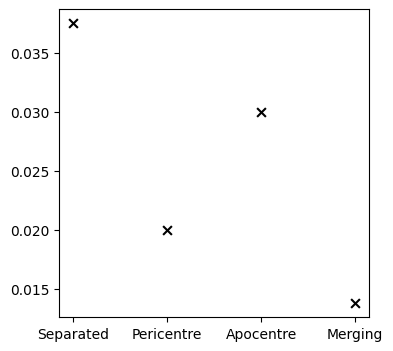

In [274]:
plt.figure(figsize = (4,4))
# plt.axhline(0.12, color = 'gray', linestyle = '--')
plt.scatter(x, fraction_list, color = 'black', s = 40, marker = 'x')
plt.errorbar(x, fraction_list, color = 'black', yerr = error_array, alpha = 0.75, linestyle = '--', capsize = 3.5)
plt.plot(x, fraction_list, color='black', linestyle='--')
plt.ylabel('Weighted AGN Fraction (N$_{AGN}$ / N$_{stage}$)')
plt.ylim([0.25,0.40])
# plt.savefig(f'{fig_folder}/agn-frac-time.pdf', bbox_inches = 'tight')
plt.show()